In [46]:
import os
import torch
import random
from tqdm import tqdm
from IPython.display import clear_output

In [47]:
if not (os.path.exists('/content/ijcnlp_dailydialog.zip') and os.path.exists('/content/ijcnlp_dailydialog')):
  print('dowloading...')
  !wget http://yanran.li/files/ijcnlp_dailydialog.zip
  !unzip /content/ijcnlp_dailydialog.zip
else:
  print('files already exists')

if not (os.path.exists('/content/data/test') and os.path.exists('/content/data/train') and os.path.exists('/content/data/validation')):
  !mkdir data
  !unzip /content/ijcnlp_dailydialog/validation.zip -d /content/data
  !unzip /content/ijcnlp_dailydialog/train.zip -d /content/data
  !unzip /content/ijcnlp_dailydialog/test.zip -d /content/data
else:
  print('files already exists')

!rm /content/ijcnlp_dailydialog.zip
!rm -r /content/ijcnlp_dailydialog

clear_output(wait=False)

In [48]:
!pip install transformers==4.38.2
clear_output(wait=False)

In [49]:
from transformers import RobertaModel, RobertaTokenizer
encoder = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
clear_output(wait=False)
print(tokenizer.pad_token_id)

1


In [50]:
# from google.colab import drive
# drive.mount("Mydrive")

In [51]:
class CustomDataset():

    def __init__(self, data_path, tokenizer, batchsize, maxlength) -> None:
        self.data = open(data_path)
        self.tokenizer = tokenizer
        self.batchsize = batchsize
        self.maxlength = maxlength
        self.data = self.custom_dataset()

    def custom_dataset(self):
        data = []
        for line in self.data:
            seqs = line.split('__eou__')
            seqs = ''.join(seqs)
            data.append(seqs)
        self.length = len(data)//self.batchsize
        return data

    def __len__(self):
        return self.length

    def batch_tokenize(self, texts):
        token_ids_batch, token_mask_batch = [], []
        # add start token
        for text in texts:
            encoded = self.tokenizer(text,
                      truncation = True,
                      padding="max_length",
                      max_length = self.maxlength,
                      return_tensors="pt")
            token_ids_batch.append(encoded)
        return token_ids_batch

    def load_batch(self, shuffle=True):
        data = self.custom_dataset()
        if shuffle:
            random.shuffle(data)

        for i in range(0, len(data), self.batchsize):
            batch_texts = data[i:i+self.batchsize]
            yield self.batch_tokenize(batch_texts)

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

In [53]:
class Model(nn.Module):
    def __init__(self, encoder, vocab_size) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder_layer = nn.Linear(768, vocab_size)

    def forward(self, x, mask):
        embeddings = self.encoder(input_ids=x, attention_mask=mask)
        embedding = embeddings.last_hidden_state
        return self.decoder_layer(embedding)

model = Model(encoder, tokenizer.vocab_size).to(device)

In [54]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
dataset = CustomDataset("/content/data/train/dialogues_train.txt", tokenizer, 4, 512)

In [55]:
import gc
torch.cuda.empty_cache()
gc.collect()

61

In [56]:
# teacher_model = Model(encoder, tokenizer.vocab_size).to(device)
# pretrained_state_dict = torch.load("/content/Mydrive/MyDrive/18786 Project/Results/big_model")
# teacher_model.load_state_dict(pretrained_state_dict)
# teacher_model.eval()
# clear_output(wait=False)

In [57]:
def validation(model, dataset, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for data_point in tqdm(dataset.load_batch(), total=dataset.length, leave=True):
            for j in range(len(data_point)):
                if j == 0:
                    x, mask = data_point[j]['input_ids'].to(device), data_point[j]["attention_mask"].to(device)
                else:
                    x, mask = torch.cat([x, data_point[j]['input_ids'].to(device)], dim=0), torch.cat([mask, data_point[j]["attention_mask"].to(device)], dim=0)

            src = x[:, :-1]
            tgt = x[:, 1: ]
            output = model(src, mask[:, :-1])
            loss = criterion(output.transpose(1,2), tgt)
            epoch_loss += loss.item()
        epoch_loss = epoch_loss/(dataset.length)
        print('pred: {}'.format(tokenizer.decode(torch.argmax(output, dim=-1)[0].tolist())))
    return epoch_loss

In [58]:
import gc
torch.cuda.empty_cache()
gc.collect()

8

In [59]:
import numpy as np
epochs = 10
training_loss = []
validation_losses = []
validation_dataset = CustomDataset("/content/data/validation/dialogues_validation.txt", tokenizer, 4, 512)
perplexity = []
for i in range(epochs):
    epoch_loss = 0
    for data_point in tqdm(dataset.load_batch(), total=dataset.length, leave=True):
        optimizer.zero_grad()
        for j in range(len(data_point)):
            if j == 0:
                x, mask = data_point[j]['input_ids'].to(device), data_point[j]["attention_mask"].to(device)
            else:
                x, mask = torch.cat([x, data_point[j]['input_ids'].to(device)], dim=0), torch.cat([mask, data_point[j]["attention_mask"].to(device)], dim=0)

        src = x[:, :-1]
        tgt = x[:, 1: ]

        output = model(src, mask[:, :-1])
        loss = criterion(output.transpose(1,2), tgt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    training_loss.append(epoch_loss/dataset.length)
    print("Training loss:", epoch_loss/dataset.length)
    val_los = validation(model, validation_dataset, criterion)
    print("Validation loss:", val_los)
    validation_losses.append(val_los)
    perplexity.append(np.exp(val_los))
    print("Perplexity:", np.exp(val_los))

2780it [17:01,  2.72it/s]


Training loss: 3.610338930948126


100%|██████████| 250/250 [00:38<00:00,  6.58it/s]


pred: I you say something about your company price?  Yes. I name from Mr up morning company and today... a little's company from English.  What was your name morning on?  My name morning is on Mr English. 
</s>How</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s

2780it [17:01,  2.72it/s]


Training loss: 1.583412715324012


100%|██████████| 250/250 [00:38<00:00,  6.57it/s]


pred: I, go and better up your products now.  Wait a moment, school.  I'm mad! I said now! Sounds off the bus, and do it now.  Mom, just ten more minutes. The show is going to be over soon.  Mr, if you don't do it soon, I will meet your products in the different can. 
</s>How</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>

2780it [17:00,  2.72it/s]


Training loss: 1.0130587495265568


100%|██████████| 250/250 [00:37<00:00,  6.60it/s]


pred: I sit down.  Thank you.  From reading over your resume, I suppose your English is quite good. Have you had any experience in the writing field?  No, I haven ’ t had any professional experience, but I have always been interested in final writing.  Have you ever had a foreign mom in English smoking?  Yes, my college teacher was an English. She was also our telephone on our English language newspaper. I was the kitchen for two years.  That ’ s very interesting. Tell me what you did exactly.  Well, I finished the Beijing of the newspaper and then I wearing several things and products to other students to write. I took the ancient each time.  What is your handle in going into the field of America?  To be different with you, I would like nothing better than to be an recently style some day.  That can be a difficult job, you know.  Yes, I know that. But I like tour and everyone in my writing.  Well, working in an ancient office may not be exciting enough for you. What do you think?  I w

2780it [16:59,  2.73it/s]


Training loss: 0.7142177012894128


100%|██████████| 250/250 [00:37<00:00,  6.59it/s]


pred: Hello!  Is that Sue?  Speaking.  A.So is George.  Hello, David.What's up? 
</s>Hi</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><

2780it [16:59,  2.73it/s]


Training loss: 0.5289690561992052


100%|██████████| 250/250 [00:37<00:00,  6.59it/s]


pred: You we have a long holiday.  Yes, what about us having a tour?  Good idea. Where shall we go?  How about Web?  Great. Shall we go alone or as part of the group?  Why not travel by ourselves? 
</s>How</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s

2780it [16:59,  2.73it/s]


Training loss: 0.40090212865875713


100%|██████████| 250/250 [00:37<00:00,  6.59it/s]


pred: It conselments of corporate soup have just reached us. We have to lamb a claim against you for superior quality I am afraid.  Is there anything wrong?  We bought 1,000 sets of corporate soup from you, but there are 40 not up to the standard.  It's hard for us to believe it. Our soup have been the best quality for years. Have you any reliable evidence?  Here is the survey report from a well-known public surveyor in London. You may establish the ancient goods personally  Well. According to the contract, we are responsible for wearing or furnished those ancient soup. We ’ ll send our buses to repair them.  Generally impossible ones means that 4 % are not up to the standard. You should confirm us for 4 % of the total account on the contract, as well as for the inspection fee.  I am sorry about the quality problem, but I propose we establish you for 3 % of the total value apart from the inspection fee.  All right. In that case we are still willing to do business with you. 
</s>How</s>

2780it [16:59,  2.73it/s]


Training loss: 0.310851618800394


100%|██████████| 250/250 [00:37<00:00,  6.59it/s]


pred: Do you have any particular conditions that you would like our company to take into consideration?  No, nothing in particular.  All right. If we decide to hire you, we'd pay you two thousand and five hundred yuan a month at the start. You can have Saturdays and weekends off. Besides, you may have a paid month holiday every year. How do you think about it?  As regards salary, I leave it to you to decide after experience of capacity.  Well, we'll give you our decision in a couple of days. It's a pleasure to talk to you, Mr. Liu.  Thank you, Mr. White. I really appreciate your assistance. 
</s>How</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></

2780it [16:59,  2.73it/s]


Training loss: 0.2441406681434596


100%|██████████| 250/250 [00:37<00:00,  6.59it/s]


pred: Are you going to vote on Tuesday?  Of course. How about you?  I ’ Ve already voted.  How ’ s that?  I sent in an absentee ballot.  Why?  I won ’ t be able to vote on Tuesday.  Why not?  I have to work.  Why don ’ t you go to work late?  I have important business to take care of that morning.  I see. 
</s>How</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><

2780it [17:00,  2.73it/s]


Training loss: 0.19406196570239048


100%|██████████| 250/250 [00:37<00:00,  6.59it/s]


pred: Good afternoon. This is Michelle Li speaking, calling on behalf of IBA. Is Mr Meng available at all?  This is Mr Meng speaking, Michelle.  Oh, hello! Sorry about that. I'm just calling to say that we've received your new Corporate Credit Card from integration.  That was quick! I wasn't expecting it until later this week.  Yes, our application procedures have speeded up since we started using the new fast-workers system.  Shall I come in and collect it?  Or we can send it to you. But if you would like to use it at the ATM, you'll need to wait for your PIN number.  Mmmm... if I come in and collect it this afternoon, is there any way I could use it today? Or cash is getting low, so I need to draw some money.  As long as you bring your ID, etc, we can serve you over the counter. But you won't be able to use the ATM until your new PIN number arrives.  I see. Yes, that's fine. I'll be there at around 2:30 pm. See you later, and thanks. 
</s>How</s></s></s></s></s></s></s></s></s></s></

2780it [17:00,  2.72it/s]


Training loss: 0.15663789563198025


100%|██████████| 250/250 [00:38<00:00,  6.56it/s]

pred: The bathroom looks lovely. Did you redecorate it yourself or did you get someone in to do it for you?  I did it myself. I went online and found a lot of website devoted to home improvement. Then I went to recover shop and bought everything I needed. I ’ m sure I saved a lot of money by doing it myself and it was fun too. I learnt a lot by doing it myself.  So, let ’ s see. You have put new tiles on the floor and slipped a few tiles on the walls. You ’ Ve also added a small cupboard for toiletries. The bath, shower, and washletsin are the same as before, aren ’ t they?  Yes, they are. I gave them a good clean. They are in good condition and don ’ t need to be slipped.  How long did it take you to do the tying.  As I hadn ’ t done it before, I had to keep referring to income 3ation I got from the internet. Doing the floor tiles took a whole day-p early morning to right through to the evening. Then I spent a few hours reminding the exhausted wall tiles. Putting the cupboard up took 

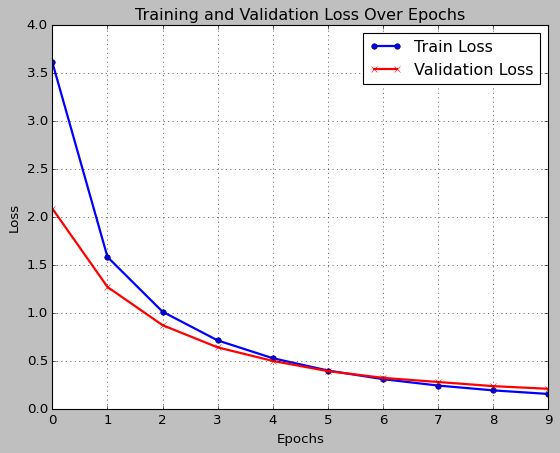

In [60]:
import matplotlib.pyplot as plt

# Use a style template
plt.style.use('classic')

# Create the plot
plt.plot(training_loss, label="Train Loss", color='blue', linewidth=2, marker='o', markersize=5)
plt.plot(validation_losses, label="Validation Loss", color='red', linewidth=2, marker='x', markersize=5)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

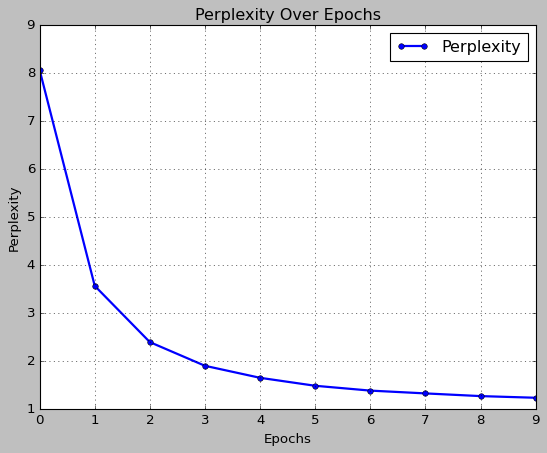

In [61]:
import matplotlib.pyplot as plt

# Use a style template
plt.style.use('classic')

# Create the plot
plt.plot(perplexity, label="Perplexity", color='blue', linewidth=2, marker='o', markersize=5)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity Over Epochs')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

In [80]:
!pip install modelsummary
clear_output(wait=False)

In [ ]:
from modelsummary import summary

input_ids = tokenizer.encode("Hello, how are you?", return_tensors='pt')
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, input_ids):
        return self.model(input_ids)

# Wrap the model
wrapped_model = ModelWrapper(model)
model.eval()
summary(wrapped_model, input_ids.shape[1:])

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/folders/1b5oqwm36yBf-ycmiM5_MYhrWhhfbC7y-/roberta_model.pth")

In [ ]:
text = "do you want to go out?"
# token = tokenizer.encode(text)
# token = torch.tensor(token)
# token = token.to(device)
# token = token.unsqueeze(0)
tokens = tokenizer(text,
    truncation = True,
    padding="max_length",
    max_length = 512,
    return_tensors="pt").to(device)
token = tokens["input_ids"]
mask = tokens["attention_mask"]
pred_tokens = []
output = model(token, mask)
pred = torch.argmax(output, dim=-1)
pred_list = pred.tolist()
print(pred_list)
#
for i in range(10):
    output = model(token, mask)
    pred = torch.argmax(output, dim=-1)
    pred_tokens.append(pred[:,-1])
    token = torch.cat([token, pred[:,-1].unsqueeze(0)], dim=1)
    mask = torch.ones_like(token)


pred_tokens = [token.item() for token in pred_tokens]
#print(pred_tokens)
pred_text = tokenizer.decode(pred_tokens)
#print(pred_text)

def inference_top_1(text, length):
    token = tokenizer.encode(text)
    token = torch.tensor(token)
    token = token.to(device)
    token = token.unsqueeze(0)
    pred_tokens = []
    mask = torch.ones_like(token)
    for i in range(length):
        output = model(token, mask)
        pred = torch.argmax(output, dim=-1)
        pred_tokens.append(pred[:,-1])
        token = torch.cat([token, pred[:,-1].unsqueeze(0)], dim=1)
        mask = torch.ones_like(token)
    pred_tokens = [token.item() for token in pred_tokens]
    predict = tokenizer.decode(pred_tokens)
    print("input text: [{}]".format(text))
    print("next words prediction : [{}]".format(predict))
    return predict

def inference_top_k(text, length):
    while True:
        token = tokenizer.encode(text)
        token = torch.tensor(token)
        token = token.to(device)
        token = token.unsqueeze(0)
        pred_tokens = []
        mask = torch.ones_like(token)
        for j in range(length):
            output = model(token, mask)
            top_five_solutions = []
            top_five_indices = torch.topk(output, k=5, dim=-1)[1]
            print(top_five_indices.shape)
            for k in range(5):
                top_five_solutions.append(tokenizer.decode(top_five_indices[:,-1,k].tolist()))

            print("Top five predictions:")
            for i, solution in enumerate(top_five_solutions):
                print(f"{i+1}: {solution}")

            user_choice = input("Choose one of the predictions (1-5), or 6 to exit: ")

            if user_choice == '6':
                print("Exiting...")
                break

            try:
                choice_index = int(user_choice) - 1
                if 0 <= choice_index < 5:
                    selected_solution = top_five_solutions[choice_index]
                    print("Selected:", selected_solution)
                    text += " " + selected_solution
                    print(text)
                else:
                    print("Invalid choice. Please choose a number between 1 and 5.")
            except ValueError:
                print("Invalid input. Please enter a number between 1 and 5, or 'stop' to exit.")

            token = torch.cat([token, top_five_indices[:,:,choice_index]], dim=1)
            mask = torch.ones_like(token)

    return text


predict = inference_top_1(text, length=10)
predict = inference_top_k(text, length=10)